In [1]:
# Import libraries
import hifive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyBigWig

In [2]:
# Load HiC project
hic = hifive.HiC("project_file.txt", "r")

# Get data for chromosome 13
data = hic.cis_heatmap("chr13", 1000000, datatype = "fend", arraytype = "full", diagonalincluded = True)

# Add pseudocount of one to each bin
data = np.add(data, 1.0)

Finding fend full array for chr13:1000000-120250001... Done


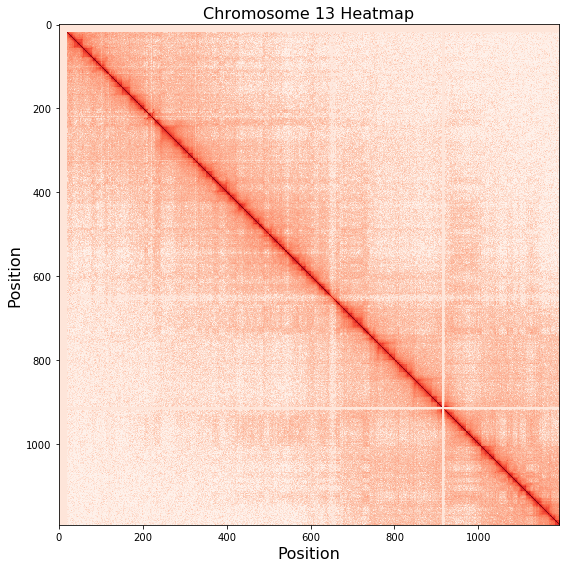

In [3]:
# Calculate enrichment scores
enrichment = data[:, :, 0] / data[:, :, 1]

# Plot enrichment scores as a heatmap
fig, ax = plt.subplots(figsize = (12, 8))

ax.imshow(np.log(enrichment), cmap = "Reds")

ax.set_title("Chromosome 13 Heatmap", fontsize = 16)
ax.set_xlabel("Position", fontsize = 16)
ax.set_ylabel("Position", fontsize = 16)

fig.tight_layout()
plt.show()

In [4]:
# Calculate compartment scores
Comp = hifive.hic_domains.Compartment(hic, 100000, chroms = ["chr13"], out_fname = "tmp.hdf5")
Comp.write_eigen_scores("hic_comp.bed")

Casting complex values to real discards the imaginary part


Casting complex values to real discards the imaginary part


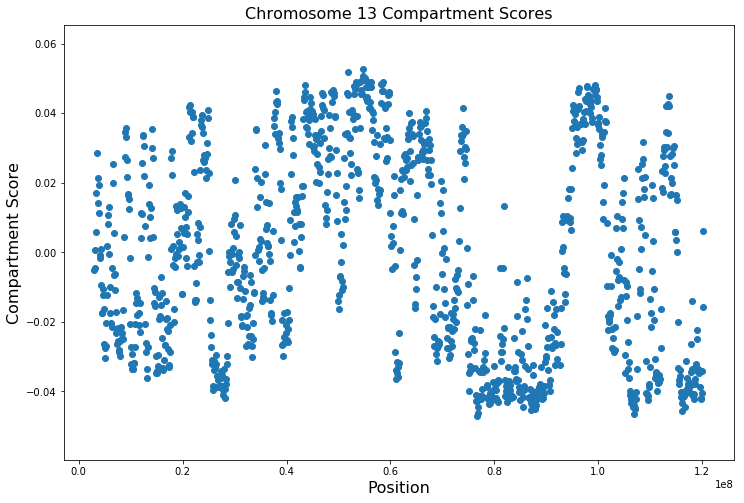

In [5]:
# Plot compartment scores

X = [pos[0] for pos in Comp.positions["chr13"]]
Y = Comp.eigenv["chr13"]

fig, ax = plt.subplots(figsize = (12, 8))

ax.scatter(X, Y)

ax.set_title("Chromosome 13 Compartment Scores", fontsize = 16)
ax.set_xlabel("Position", fontsize = 16)
ax.set_ylabel("Compartment Score", fontsize = 16)

plt.show()

In [6]:
%%bash

# Identify the compartment a gene overlapped by at least 50%

bedtools intersect -wa -wb -f 0.50 \
    -a data/WT_fpkm.bed \
    -b hic_comp.bed \
    > gene_compartments.bed

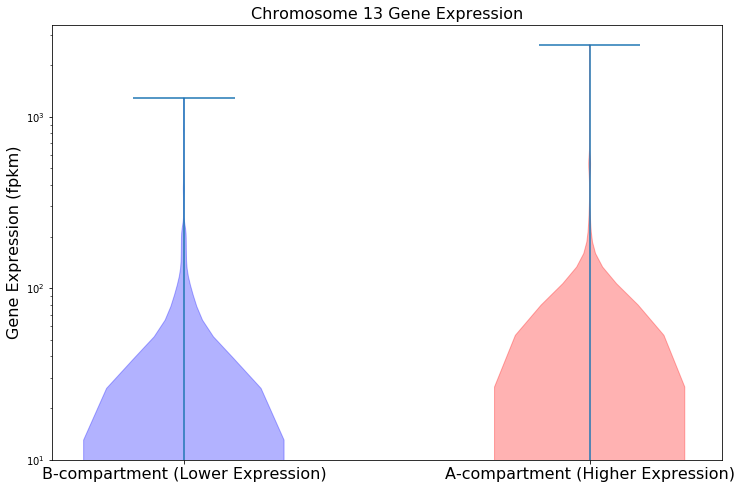

In [7]:
# Read in gene-compartment data
gene_compartments = pd.read_csv("gene_compartments.bed", sep = "\t", header = None)

# Plot gene expression stratified by positive or negative enrichment score
fig, ax = plt.subplots(figsize = (12, 8))

violin_plot = ax.violinplot([gene_compartments[4][gene_compartments[8] >= 0].values, 
             gene_compartments[4][gene_compartments[8] < 0].values])

for violin, color in zip(violin_plot['bodies'], ["blue", "red"]):
    violin.set_color(color)

ax.set_title("Chromosome 13 Gene Expression", fontsize = 16)
ax.set_xticks([1, 2])
ax.set_xticklabels(["B-compartment (Lower Expression)", "A-compartment (Higher Expression)"], 
                  fontsize = 16)
ax.set_yscale("log")
ax.set_ylabel("Gene Expression (fpkm)", fontsize = 16)

plt.show()

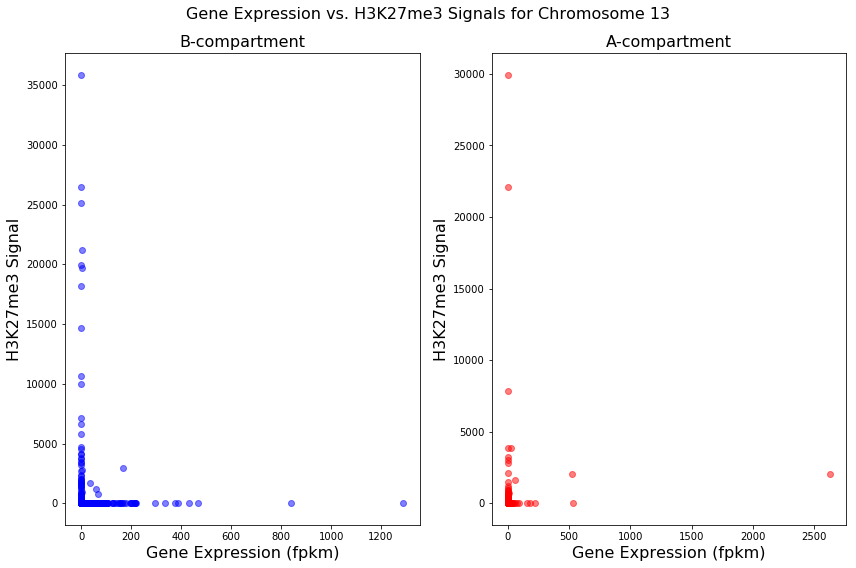

In [8]:
# Extract H3K27me3 data for chromosome 13
bw = pyBigWig.open("data/WT_H3K27me3.bw")

# Get H3K27me3 signal for each gene
gene_compartments["H3K27me3"] = gene_compartments.apply(lambda row: bw.stats("chr13", row[1], row[2], type = "sum"), axis = 1, result_type = "expand")
gene_compartments["H3K27me3"].fillna(0, inplace = True)

# Plot gene expression versus H3K27me3 signals
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 8))

ax1.scatter(gene_compartments[4][gene_compartments[8] >= 0], 
            gene_compartments["H3K27me3"][gene_compartments[8] >= 0], 
           alpha = 0.5, color = "blue")

ax1.set_title("B-compartment", fontsize = 16)
ax1.set_xlabel("Gene Expression (fpkm)", fontsize = 16)
ax1.set_ylabel("H3K27me3 Signal", fontsize = 16)

ax2.scatter(gene_compartments[4][gene_compartments[8] < 0], 
            gene_compartments["H3K27me3"][gene_compartments[8] < 0], 
           alpha = 0.5, color = "red")

ax2.set_title("A-compartment", fontsize = 16)
ax2.set_xlabel("Gene Expression (fpkm)", fontsize = 16)
ax2.set_ylabel("H3K27me3 Signal", fontsize = 16)

plt.suptitle("Gene Expression vs. H3K27me3 Signals for Chromosome 13", fontsize = 16)

fig.tight_layout()
plt.subplots_adjust(top = 0.90)
plt.show()